# Système linéaire invariant avec retard pur

## Introduction

L'étude de la stabilité d'un système bouclé en présence d'un retard pur ne peut pas faire appel à certains critères classiques utilisés pour les systèmes linéaires invariants, tels que les propriétés sur les pôles ou les critères algébriques (Routh). Le seul critère qui aboutit dans ce contexte est le critère du revers appliqué sur le diagramme de Nyquist de la boucle ouverte.

## Les packages utiles

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
import control as ct
import matplotlib.pyplot as plt

## Fonction de tracé avec retard pour Nyquist

In [2]:
def mynyquist(H, T, wlim, titre):
    G, P, w = ct.frequency_response(H, omega_limits=wlim)
    plt.figure()
    plt.plot(G*np.cos(P-T*w), G*np.sin(P-T*w), 'b', label='$H(j\\omega)$')
    plt.plot(G*np.cos(P-T*w), -G*np.sin(P-T*w), 'r', label='$H(-j\\omega)$')
    plt.plot(-1, 0, 'ok', label='point critique')
    plt.legend()
    plt.xlabel('$Re(H(p))$')
    plt.ylabel('$Im(H(p))$')
    plt.grid('on')
    plt.axis('equal')
    plt.title(titre)
    plt.show()

## Exemple choisi

Pour l'exemple, la fonction de transfert $\mu(p)\beta(p)$ en boucle ouverte est exprimée avec $\mu(p)=\dfrac{K}{1+\tau p}$ et $\beta(p)=\exp(-Tp)$.

In [3]:
p = ct.tf('s')
tau, K, T = 2.0, 16.35, 0.2
H = K/(1+tau*p)

## Diagramme de Nyquist de la boucle ouverte

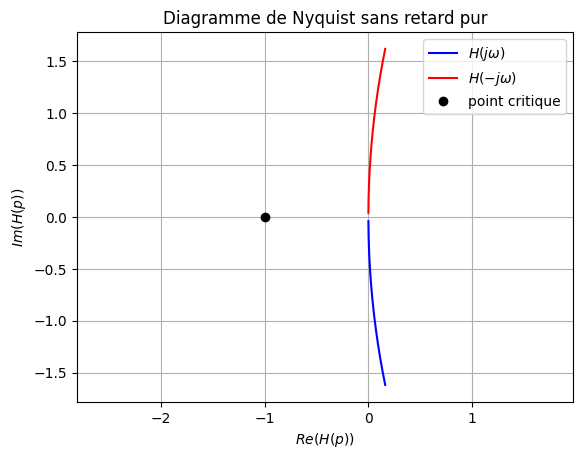

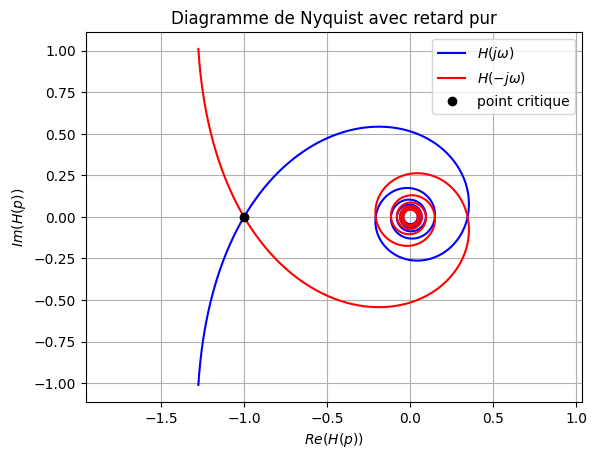

In [4]:
G, P, w = ct.frequency_response(H, omega_limits=[5, 200])

mynyquist(H, 0, [5, 200], 'Diagramme de Nyquist sans retard pur')

mynyquist(H, T, [5, 200], 'Diagramme de Nyquist avec retard pur')

## Equation différentielle avec retard pour la boucle fermée

En boucle fermée :

$$\dfrac{\mu(p)}{1+\mu(p)\beta(p)}=\dfrac{K}{1+\tau p+K\exp(-Tp)}=\dfrac{Y(p)}{U(p)}$$

L'équation différentielle  associée est :

$$y'(t) = -\dfrac{y(t)}{\tau}-\dfrac{Ky(t-T)}{\tau}+\dfrac{Ku(t)}{\tau}=F(t,y(t),y(t-T),u(t))$$

Il s'agit d'une EDR (Equation Différentielle avec Retard).

## Résolution numérique par la méthode des pas

L'intervalle de temps sur lequel on évalue numériquement la solution est découpé en intervalles de longueur $T$. Dans chaque intervalle $[nT, (n+1)T]$ avec $n$ entier, la fonction $y(t-T)$ est la solution obtenue dans l'intervalle précédent. Pour $n=0$, on suppose que $y(t-T)=0$. On s'intéresse par ailleurs à la réponse indicielle, avec $u(t)=1$ pour $t \geq 0$.

In [5]:
def u(t):
    return 1.0


def F(t, y, yT, u, K, tau):
    return -y/tau-(K/tau)*yT[0]+(K/tau)*u


def resol_edr(K, tau, T, NT):
    def yT(t): return [0.0]
    for nT in range(0, NT):
        sol = solve_ivp(lambda t, y: F(t, y, yT(t-T), u(t), K, tau),
                        [nT*T, (nT+1)*T], yT(nT*T), rtol=1e-10, atol=1e-10)
        t = sol.t.T
        y = sol.y.T
        plt.plot(t, y, 'b')
        yT = CubicSpline(t, y)
    plt.grid('on')
    plt.show()

La résolution numérique est effectuée pour le gain $K$ faisant passer le lieu de Nyquist par le point critique $-1$.

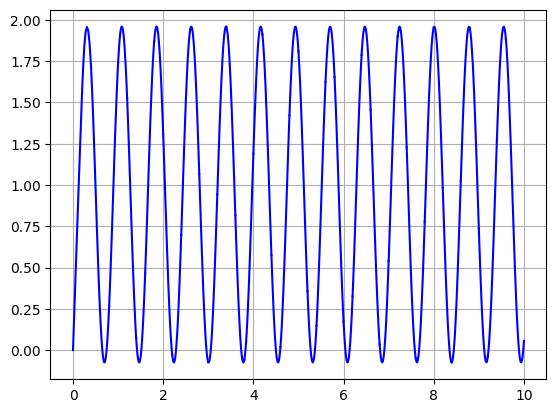

In [6]:
resol_edr(K, tau, T, 50)

## Conclusion de l'essai en réponse indicielle

Pour un lieu de Nyquist passant par le point critique $-1$, on retrouve bien une solution $y(t)$ qui oscille indéfiniment.

## Approximation de Pade

La fonction de transfert $\exp(-Tp)$ du retard pur peut être approximée par une fonction de transfert $R(p)$ qui est une fraction rationnelle. On retrouve ainsi un système linéaire invariant sans retard, dont l'étude de la stabilité peut reprendre les outils classiques.

In [7]:
num, den = ct.pade(T, 4)
R = ct.tf(num, den)
R

TransferFunction(array([ 1.00e+00, -1.00e+02,  4.50e+03, -1.05e+05,  1.05e+06]), array([1.00e+00, 1.00e+02, 4.50e+03, 1.05e+05, 1.05e+06]))

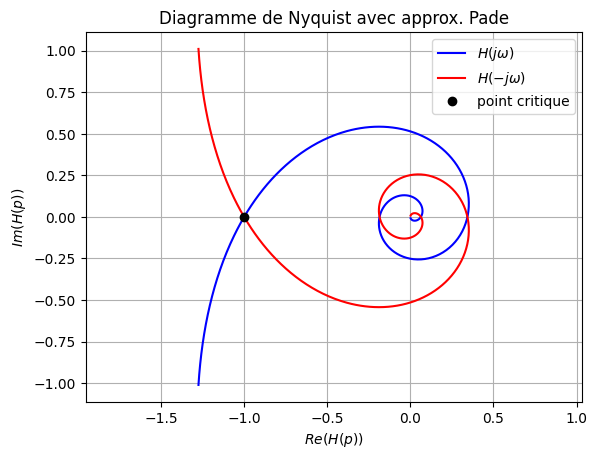

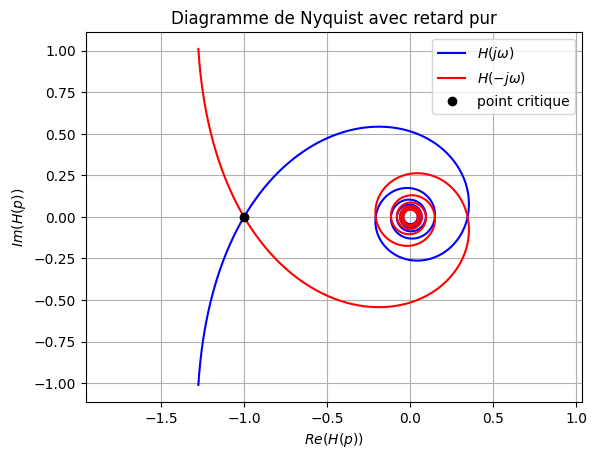

In [8]:
mynyquist(H*R, 0, [5, 1000], 'Diagramme de Nyquist avec approx. Pade')

mynyquist(H, T, [5, 200], 'Diagramme de Nyquist avec retard pur')